In [1]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import joblib
import random

from CRISMrelatedMethods.dataRead import *
from CRISMrelatedMethods.preprocessing import *
from CRISMrelatedMethods.preprocess_pipeline import *

In [2]:
def getAreaSegments(O,areaCutOff=0.05,noOfSegsCutOff=None,fwhm=False,doPrint=False):
    if doPrint: print("******************************")
    if doPrint: print("***getAreaSegments","areaCutOff",areaCutOff,"noOfSegsCutOff",noOfSegsCutOff,"fwhm",fwhm)
    if doPrint: print("******************************")
    O=np.round(O,4)
    segInfo=[]
    segStart=False
    m=np.max(O)
    if doPrint: print("m",m)
    for o in range(1,len(O)):
        if not segStart and np.isclose(O[o-1],m,atol=1e-03) and O[o]<m:
            segStart=True
            newSeg={'start':o-1,'area':0,'min':[o],'ref_val':[O[o-1],O[o]]}
        elif segStart and np.isclose(O[o],m,atol=1e-03) and O[o-1]<m:
            newSeg['ref_val'].append(O[o])
            segStart=False
            newSeg['end']=o
            newSeg['min']=np.median(newSeg['min'])
            newSeg['ref_val']=np.array(newSeg['ref_val'])
            segInfo.append(newSeg)
        elif segStart:
            newSeg['area']+=(m-O[o])
            newSeg['ref_val'].append(O[o])
            if O[newSeg['min'][0]]==O[o]:
                newSeg['min'].append(o)
            elif O[newSeg['min'][0]]>O[o]:
                newSeg['min']=[o]
                
        
    totalSegArea=np.sum([segInfo[s]['area'] for s in range(len(segInfo))])
    totalSegLen=np.sum([spectralWavelengthSet[segInfo[s]['end']]-spectralWavelengthSet[segInfo[s]['start']] for s in range(len(segInfo))])
    for S in segInfo:
        S['areaWeight_spec']=S['area']/totalSegArea
        S['lenWeight_spec']=(spectralWavelengthSet[S['end']]-spectralWavelengthSet[S['start']])/totalSegLen
        
    if doPrint: print("--> len(segInfo)",len(segInfo))
        
    if noOfSegsCutOff is None and areaCutOff is None:
        deleteSeg=[]
    elif noOfSegsCutOff is None and areaCutOff is not None:
        deleteSeg=[s for s in range(len(segInfo)) if segInfo[s]['areaWeight_spec']<areaCutOff]
#             deleteSeg=[s for s in range(len(segInfo)) if segInfo[s]['lenWeight_spec']<areaCutOff]
    elif noOfSegsCutOff is not None and areaCutOff is None:
        deleteSeg=[segInfo[s]['areaWeight_spec'] for s in range(len(segInfo))]
        if doPrint: print(deleteSeg)
        deleteSeg=list(np.argsort(deleteSeg)[:-noOfSegsCutOff])
    elif noOfSegsCutOff is not None and areaCutOff is not None:
        areaCutOffLen=len([s for s in range(len(segInfo)) if segInfo[s]['areaWeight_spec']>areaCutOff])
        if doPrint: print("areaCutOffLen",areaCutOffLen)
        deleteSeg=[segInfo[s]['areaWeight_spec'] for s in range(len(segInfo))]
        if doPrint: print(deleteSeg)
        deleteSeg=list(np.argsort(deleteSeg)[:-min(areaCutOffLen,noOfSegsCutOff)])

    if doPrint: print('before delete len(segInfo)',len(segInfo))
    if doPrint: print(deleteSeg)
    deleteSeg.sort()
    deleteSeg.reverse()
    for d in deleteSeg:
        segInfo.pop(d)
        
    if doPrint: print('after delete len(segInfo)',len(segInfo))
    totalSegArea=np.sum([segInfo[s]['area'] for s in range(len(segInfo))])
    totalSegLen=np.sum([spectralWavelengthSet[segInfo[s]['end']]-spectralWavelengthSet[segInfo[s]['start']] for s in range(len(segInfo))])
    for S in segInfo:
        S['areaWeight_spec']=S['area']/totalSegArea
        S['lenWeight_spec']=(spectralWavelengthSet[S['end']]-spectralWavelengthSet[S['start']])/totalSegLen
        if fwhm:
            hw=O[int(S['min'])]+(m-O[int(S['min'])])/2
            if doPrint: print(int(S['start']),int(S['min']),int(S['end']),hw)
            for i in range(int(S['start'])+1,int(S['min'])+1):
                if doPrint: print('fw_s i',i,'O[i]',O[i],spectralWavelengthSet[i])
                if np.isclose(O[i],hw,atol=1e-03):
                    fw_s=spectralWavelengthSet[i]
                    break
                elif O[i]<hw and O[i-1]>hw:
                    fw_s=spectralWavelengthSet[i-1]+(spectralWavelengthSet[i]-spectralWavelengthSet[i-1])*((O[i-1]-hw)/(O[i-1]-O[i]))
                    break
            if doPrint: print("i-1,i,O[i],O[i-1],fw_s,(O[i-1]-hw),(O[i-1]-O[i])",i-1,i,O[i],O[i-1],fw_s,(O[i-1]-hw),(O[i-1]-O[i]))
            for i in range(int(S['end'])-1,int(S['min'])-1,-1):
                if doPrint: print('fw_e i',i,'O[i]',O[i],spectralWavelengthSet[i])
                if np.isclose(O[i],hw,atol=1e-03):
                    fw_e=spectralWavelengthSet[i]
                    break
                elif O[i+1]>hw and O[i]<hw:
                    fw_e=spectralWavelengthSet[i+1]-(spectralWavelengthSet[i+1]-spectralWavelengthSet[i])*((O[i+1]-hw)/(O[i+1]-O[i]))
                    break
            if doPrint: print("i+1,i,O[i],O[i+1],fw_e,(O[i+1]-hw),(O[i+1]-O[i])",i+1,i,O[i],O[i+1],fw_e,(O[i+1]-hw),(O[i+1]-O[i]))
            if doPrint: print('fw_e-fw_s',fw_e-fw_s)
            S['fwhm']=fw_e-fw_s
            S['hw_fws_fwe']=(hw,fw_s,fw_e)
    if doPrint: print("------------------------------")
    if doPrint: print("------------------------------")
    return segInfo

In [3]:
def clark_corr_coef(O,L):
    if L[0]==np.Inf or O[0]==np.Inf: return -np.Inf
    def getLinFit_b(S1,S2):
#         print(len(S1),len(S2))
        num=(np.sum(S1*S2)-((np.sum(S1)*np.sum(S2))/len(S1)))
        den=(np.sum(S2*S2)-(((np.sum(S2))**2)/len(S1)))
        return (np.abs(num)/np.abs(den))*(num/np.abs(num)) if num!=0 and den!=0 else 0
    b,b_=getLinFit_b(O,L),getLinFit_b(L,O)
    F=np.sqrt(np.abs(b)*np.abs(b_))*(b/np.abs(b)) if b!=0 and b_!=0 else 0
    return F
def clark_corr_coef_shift(O,L,start,end,shift=5):
    maxMatch=-np.Inf
    for i in range(-int(shift/2),int(shift/2)+1):
        if start+i<0:continue
        if end+i>len(O)-1:continue
        thisMatch=clark_corr_coef(L[start:end],O[start+i:end+i])
        if maxMatch<thisMatch:
            maxMatch=thisMatch
    return maxMatch

In [7]:
specifications=joblib.load('specifications.z')

mineralNames=specifications['mineralNames']
mineralNamesPrint=specifications['mineralNamesPrint']
spectralWavelengthSet=specifications['spectralWavelengthSet']
mineralGroupNames=specifications['mineralGroupNames']
mineralGroupList=specifications['mineralGroupList']
spectralWavelength=specifications['spectralWavelength']
spectralIF=specifications['spectralIF']
MTRDRdata_wavelengths=specifications['MTRDRdata_wavelengths']

prepSteps='crSRsmsmSSCC'
smParams={'smWindow':43,'stdRatio':0}
ccParams={'wavelengths':spectralWavelengthSet,'method':'sub','recursion':False,'fitpoints':'maxima','selectedPoints':False,'segMaximaLimit':3}
crParams={'sourceWl':MTRDRdata_wavelengths,'targetWl':spectralWavelengthSet}
uchParams={'wavelengths':spectralWavelengthSet,'method':'sub'}
ghParams={'wavelengths':spectralWavelengthSet,'method':'sub','iteration':True}
shParams={'wavelengths':spectralWavelengthSet,'method':'sub'}

def getLibSpectra(prepSteps='',smParams={},crParams={},CCParams={},UCHparams={},SHParams={},GHParams={},plebani=False,doPrint=False,col=1):
    spectralWavelength,spectralIF,spectralFiles,mineralNames,_=readSpectralLib('spectralLibrary/',startW=1.0472,endW=2.64834,col=col)

    libSpectras=[]
    for m in range(len(specifications['mineralNames'])):
        if plebani and plebaniMICAclass_rev.get(m) is None: 
            libSpectras.append(np.full(spectralWavelengthSet.shape,np.Inf))
            continue
            
        crParams['sourceWl']=spectralWavelength[m]
        if prepSteps[:2]!='cr': prepSteps='cr'+prepSteps
        
        pixelSpectraPrep=getPreProcessed(np.array(spectralIF[m]),prepSteps=prepSteps,smParams=smParams,CRparams=crParams,
                                         CCParams=CCParams,UCHparams=UCHparams,SHParams=SHParams,GHParams=GHParams)
        libSpectras.append(pixelSpectraPrep)
    return np.array(libSpectras)

In [6]:
# imageFile="rawData/data_5/MROCR_4001/mrocr_4001/mtrdr/2008/2008_006/frt000093be/frt000093be_07_if166j_mtr3.img"
# hdrFile="rawData/data_5/MROCR_4001/mrocr_4001/mtrdr/2008/2008_006/frt000093be/frt000093be_07_if166j_mtr3.HDR"
# dataName='data5'

imageFile="rawData/data_9/MROCR_4001/mrocr_4001/mtrdr/2009/2009_200/frt00013d1f/frt00013d1f_07_if164j_mtr3.img"
hdrFile="rawData/data_9/MROCR_4001/mrocr_4001/mtrdr/2009/2009_200/frt00013d1f/frt00013d1f_07_if164j_mtr3.HDR"
dataName='data9'

wavelengths,image,LINES,LINE_SAMPLES,BANDS,imageFrame=readImage(hdrFile,imageFile)

print("\n")
print("len(wavelengths)",len(wavelengths))

imgdata=np.swapaxes(np.swapaxes(image,0,2),0,1).reshape(-1,BANDS)
framedata=imageFrame.reshape(LINES*LINE_SAMPLES)

imgdata2=imgdata.reshape(LINES,LINE_SAMPLES,BANDS)
imgdata3=imgdata2[::2,::2,:]
IMGframe=imageFrame[::2,::2]

joblib.dump(imgdata3,'WSSCresults/MTRDR/'+dataName+'_alter2_rawData.z')
joblib.dump(IMGframe,'WSSCresults/MTRDR/'+dataName+'_alter2_IMGframe.z')
print("imgdata3.shape",imgdata3.shape)
print("IMGframe[0,0]",IMGframe[0,0])
print("np.sum(IMGframe)/(IMGframe.shape[0]*IMGframe.shape[1])",np.sum(IMGframe)/(IMGframe.shape[0]*IMGframe.shape[1]))

648 800 489
bsq Nanometers
(489, 648, 800)
image read as bsq


len(wavelengths) 489
imgdata3.shape (324, 400, 489)
IMGframe[0,0] True
np.sum(IMGframe)/(IMGframe.shape[0]*IMGframe.shape[1]) 0.38983796296296297


In [73]:
imgdata3.shape, IMGframe[0,0]

((324, 400, 489), True)

In [194]:
IMG2=np.zeros((imgdata3.shape[0],imgdata3.shape[1],len(spectralWavelengthSet)))
for i in range(imgdata3.shape[0]):
    print(imgdata3.shape[0]-i)
    for j in range(imgdata3.shape[1]):
        if IMGframe[i,j]: continue
        IMG2[i,j]=getPreProcessed(imgdata3[i,j],
                                    prepSteps=prepSteps,
                                    CRparams=crParams,
                                    CCParams=ccParams,
                                    GHParams=ghParams,
                                    SHParams=shParams,
                                    UCHparams=uchParams,
                                    smParams=smParams) 
joblib.dump(IMG2,'WSSCresults/MTRDR/'+dataName+'_alter2_prep_'+prepSteps+'_smWindow'+str(smParams['smWindow'])+'_segMaximaLimit'+str(ccParams['segMaximaLimit'])+'.z')

324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
6

['WSSCresults/MTRDR/data9_alter2_prep_crSRsmsmSSCC_smWindow43_segMaximaLimit3.z']

In [7]:
areaCutOffLib=.05
noOfSegsCutOffLib=None
shift=1

libSpectra_Prep=getLibSpectra(prepSteps=prepSteps,smParams=smParams,CCParams=ccParams,crParams=crParams,UCHparams=uchParams,GHParams=ghParams,SHParams=shParams)
lib_areaSegments_Prep=[getAreaSegments(l,noOfSegsCutOff=noOfSegsCutOffLib,areaCutOff=areaCutOffLib,fwhm=True) for l in libSpectra_Prep]

NameError: name 'crParams' is not defined

In [196]:
# dataName='data5'
# prepSteps='crSRsmsmSSCC'
# ccParams['segMaximaLimit']=1
# smParams['smWindow']=21

IMG2_path='WSSCresults/MTRDR/'+dataName+'_alter2_prep_'+prepSteps+'_smWindow'+str(smParams['smWindow'])
similarity_path='WSSCresults/MTRDR/'+dataName+'_similarity_'+prepSteps+'_smWindow'+str(smParams['smWindow'])
if 'CC' in prepSteps: 
    IMG2_path+='_segMaximaLimit'+str(ccParams['segMaximaLimit'])
    similarity_path+='_segMaximaLimit'+str(ccParams['segMaximaLimit'])
IMG2=joblib.load(IMG2_path+'.z')

wt='areaWeight_spec'

similarity=np.zeros((IMG2.shape[0],IMG2.shape[1],len(mineralNames)))
for i in range(IMG2.shape[0]):
    print(IMG2.shape[0]-i)
    for j in range(IMG2.shape[1]):
        if IMGframe[i,j]: continue
        for k in range(len(lib_areaSegments_Prep)):
            similarity[i,j,k]=sum([S[wt]*clark_corr_coef_shift(IMG2[i,j],libSpectra_Prep[k],S['start'],S['end'],shift=shift)
                                    for S in lib_areaSegments_Prep[k]
                                  ])
joblib.dump(similarity,similarity_path+'.z')

324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
6

['WSSCresults/MTRDR/data9_similarity_crSRsmsmSSCC_smWindow43_segMaximaLimit3.z']

In [120]:
print(mineralNames)

{0: 'alunite', 1: 'al_smectite', 2: 'analcime', 3: 'bassanite', 4: 'chloride', 5: 'chlorite', 6: 'co2_ice', 7: 'epidote', 8: 'fe_ca_carbonate', 9: 'fe_olivine', 10: 'fe_smectite', 11: 'gypsum', 12: 'h2o_ice', 13: 'hcp', 14: 'hematite', 15: 'hydrated_silica', 16: 'hydrox_fe_sulf', 17: 'illite_muscovite', 18: 'jarosite', 19: 'kaolinite', 20: 'lcp', 21: 'margarite', 22: 'mg_carbonate', 23: 'mg_olivine', 24: 'mg_smectite', 25: 'mono_hyd_sulf', 26: 'plagioclase', 27: 'poly_hyd_sulf', 28: 'prehnite', 29: 'serpentine', 30: 'talc'}


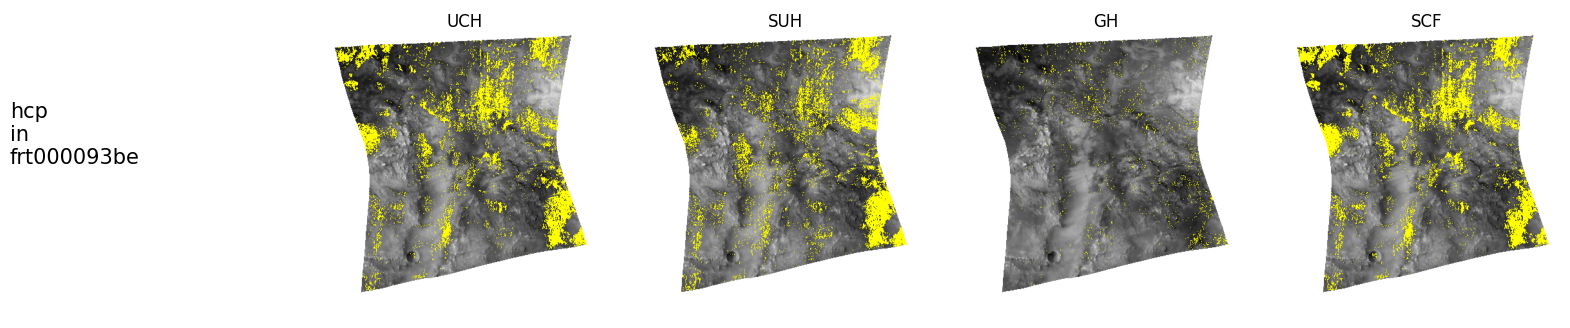

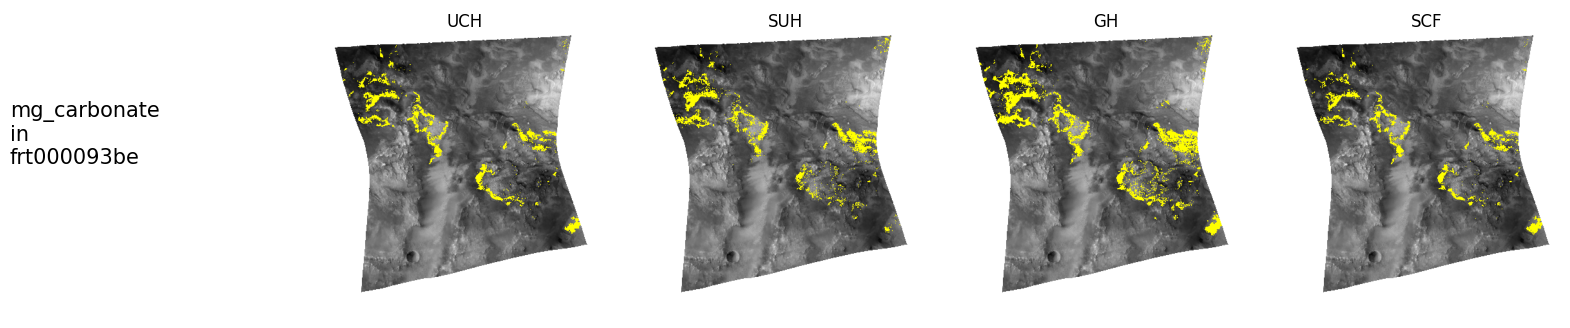

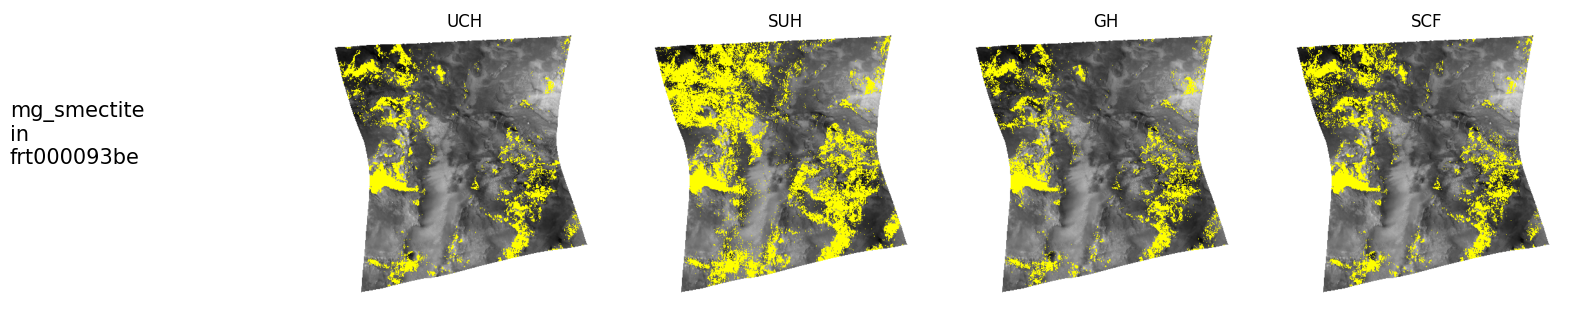

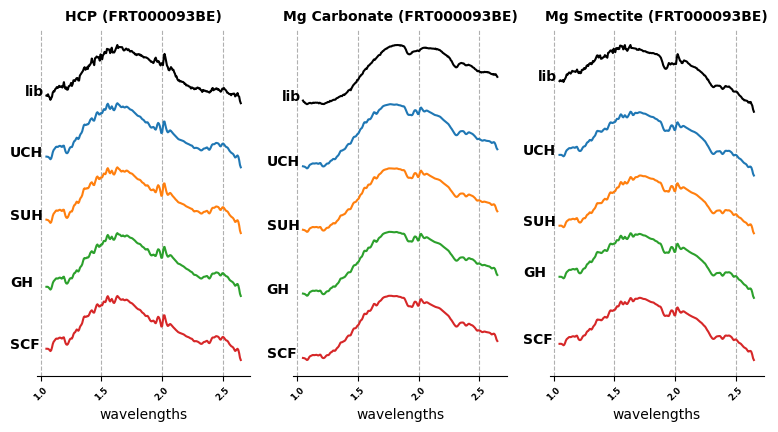

In [10]:
# mineralIndices=[11,20]
# dataName='data9'
mineralIndices=[13,22,24]
dataName='data5'

imageName='frt000093be' if dataName=='data5' else 'frt00013d1f'if dataName=='data9' else ''

rawData=joblib.load('WSSCresults/MTRDR/'+dataName+'_alter2_rawData.z')
IMGframe=joblib.load('WSSCresults/MTRDR/'+dataName+'_alter2_IMGframe.z')

preps=['CR','SH','GH','CC']


samples={m:{pr:[] for pr in preps} for m in mineralIndices}
sampleCount={m:{pr:0 for pr in preps} for m in mineralIndices}
for m in range(len(mineralIndices)):
    fig=plt.figure(figsize=((len(preps)+1)*4,4))
    ax = fig.add_subplot(1,len(preps)+1,1)
    ax.text(0,0,mineralNames[mineralIndices[m]]+'\nin\n'+imageName,fontsize=15)
    ax.axis("off")
    ax.set_ylim(-.5,.5)
    for pr in range(len(preps)):
        prepSteps='crSRsmsmSS'+preps[pr]
        smParams['smWindow']=21

        IMG2_path='WSSCresults/MTRDR/'+dataName+'_alter2_prep_'+prepSteps
        similarity_path='WSSCresults/MTRDR/'+dataName+'_similarity_'+prepSteps
        if 'CC' in prepSteps: 
            ccParams['segMaximaLimit']=0
            if mineralIndices[m] in mineralGroupList[0] or mineralIndices[m] in mineralGroupList[5]: 
                ccParams['segMaximaLimit']=3
                smParams['smWindow']=43
        IMG2_path+='_smWindow'+str(smParams['smWindow'])
        similarity_path+='_smWindow'+str(smParams['smWindow'])
        if 'CC' in prepSteps: 
            IMG2_path+='_'+'segMaximaLimit'+str(ccParams['segMaximaLimit'])
            similarity_path+='_'+'segMaximaLimit'+str(ccParams['segMaximaLimit'])
        IMG2=joblib.load(IMG2_path+'.z')
        similarity=joblib.load(similarity_path+'.z')

        mineralThreshold={24:.8,22:.8,13:.7,20:.8,11:.8}

        topk=3

        similaritytopk=np.zeros((similarity.shape[0],similarity.shape[1]))
        for i in range(similarity.shape[0]):
            for j in range(similarity.shape[1]):
                if not np.isclose(np.sum(similarity[i,j]),0):
                    if similarity[i,j][mineralIndices[m]]<.7: continue #mineralThreshold[mineralIndices[m]]
                    if mineralIndices[m] not in np.argsort(similarity[i,j])[::-1][:topk]: continue
                    similaritytopk[i,j]=similarity[i,j][mineralIndices[m]]


        B=np.copy(IMGframe)
        minB=np.min(rawData[:,:,100])
        maxB=np.max(np.where(IMGframe[:,:],0,rawData[:,:,100]))
        B=np.where(IMGframe,IMGframe,(rawData[:,:,100]-minB)/(maxB-minB))
        # B=np.where(IMGframe,np.max(B),B)
        B_rgb=np.repeat(np.expand_dims(B,axis=2),3, axis=2)

        for i in range(similarity.shape[0]):
            for j in range(similarity.shape[1]):
                if similaritytopk[i,j]>0:
#                     B_rgb[i,j]=[similaritytopk[i,j],similaritytopk[i,j],0]
                    B_rgb[i,j]=[1,1,0]
                    if random.randint(0, 20)%11==0:
                        samples[mineralIndices[m]][preps[pr]].append(rawData[i,j])
                        sampleCount[mineralIndices[m]][preps[pr]]+=1

        
        ax = fig.add_subplot(1,len(preps)+1,pr+2)
        ax.imshow(B_rgb)
        ax.axis("off")
        extent = ax.get_tightbbox().transformed(fig.dpi_scale_trans.inverted()) #get_window_extent
        fig.savefig('WSSCresults/MTRDR/'+dataName+'_'+mineralNames[mineralIndices[m]]+'_'+prepSteps+'.png',dpi=100, bbox_inches=extent,pad_inches = 0)
#         plt.savefig('WSSCresults/MTRDR/'+dataName+'_'+mineralNames[mineralIndices[m]]+'_'+prepSteps+'.png',dpi=100, bbox_inches = 'tight')
        title='UCH' if preps[pr]=='CR' else 'SUH' if preps[pr]=='SH' else 'GH' if preps[pr]=='GH' else 'SCF' if preps[pr]=='CC' else ''
        ax.set_title(title)
    plt.show()
    
libSpectra=getLibSpectra(prepSteps='SS',smParams=smParams,crParams=crParams,col=3)
fig=plt.figure(figsize=((len(preps))*4,4.5))
for m in range(len(mineralIndices)):
    ax = fig.add_subplot(1,len(preps)+1,m+2)
    ax.plot(spectralWavelengthSet,libSpectra[mineralIndices[m]],color='black')
    ax.text(spectralWavelengthSet[0]-.175,libSpectra[mineralIndices[m]][0],'lib',color='black',fontweight='bold')
    prevPlotBottom=np.min(libSpectra[mineralIndices[m]])
    for pr in range(len(preps)):
        P=np.mean(samples[mineralIndices[m]][preps[pr]],axis=0)
        prepP=getPreProcessed(P,prepSteps='crsmsmSS',CRparams={'sourceWl':MTRDRdata_wavelengths,'targetWl':spectralWavelengthSet})
        thisPlotTop=np.max(prepP)
        shiftUp=prevPlotBottom-thisPlotTop
        shiftedP=prepP+shiftUp
        ax.plot(spectralWavelengthSet,shiftedP)
        title='UCH' if preps[pr]=='CR' else 'SUH' if preps[pr]=='SH' else 'GH' if preps[pr]=='GH' else 'SCF' if preps[pr]=='CC' else ''
        ax.text(spectralWavelengthSet[0]-.3,shiftedP[0],title,color='black',fontweight='bold')
        prevPlotBottom=np.min(shiftedP)
    ax.set_xticks(np.arange(1,3,.5),np.arange(1,3,.5),fontweight='bold',rotation=45,fontsize=6)
    ax.set_xlabel('wavelengths')
    ax.set_yticks([])
    ax.set_title(mineralNamesPrint[mineralIndices[m]]+' ('+imageName.upper()+')',fontweight='bold',fontsize=10)
    ax.spines[['right', 'left', 'top']].set_visible(False)
    ax.grid(linestyle='--')
    extent = ax.get_tightbbox().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('WSSCresults/MTRDR/'+dataName+'_spectraMatch'+'_'+mineralNames[mineralIndices[m]]+'.png',dpi=100, bbox_inches=extent,pad_inches = 0)
plt.show()